In [ ]:
!pip install gdown
!gdown 1aaOaAM0iidmkR0mHkPOIwddpkpzBmlWT

In [ ]:
import re
import ast
import json
from glob import glob
from collections import Counter
from scipy.stats import pearsonr,spearmanr
from numpy import mean, median

In [2]:
def extract_apis(code):
    tree = ast.parse(code)
    api_list = []
    imported_modules = {}

    class ApiExtractor(ast.NodeVisitor):
        def visit_Import(self, node):
            for alias in node.names:
                module_name = alias.name
                alias_name = alias.asname or alias.name
                imported_modules[alias_name] = module_name
                # Add submodule and top-level module
                submodule_parts = module_name.split('.')
                for i in range(1, len(submodule_parts) + 1):
                    submodule = '.'.join(submodule_parts[:i])
                    imported_modules[submodule] = submodule
            self.generic_visit(node)

        def visit_ImportFrom(self, node):
            module = node.module
            if module:
                for alias in node.names:
                    full_name = f'{module}.{alias.name}'
                    alias_name = alias.asname or alias.name
                    imported_modules[alias_name] = full_name
            self.generic_visit(node)

        def visit_Attribute(self, node):
            if isinstance(node.value, ast.Name) and node.value.id in imported_modules:
                base_module = imported_modules[node.value.id]
                api_call = f"{base_module}.{node.attr}"
                if api_call not in api_list:
                    api_list.append(api_call)
            self.generic_visit(node)

        def visit_Call(self, node):
            if isinstance(node.func, ast.Attribute):
                attr_parts = []
                current = node.func
                while isinstance(current, ast.Attribute):
                    attr_parts.append(current.attr)
                    current = current.value

                if isinstance(current, ast.Name) and current.id in imported_modules:
                    base_module = imported_modules[current.id]
                    attr_parts.append(base_module)
                    attr_parts.reverse()
                    api_call = '.'.join(attr_parts)
                    if api_call not in api_list:
                        api_list.append(api_call)
            elif isinstance(node.func, ast.Name) and node.func.id in imported_modules:
                api_call = imported_modules[node.func.id]
                if api_call not in api_list:
                    api_list.append(api_call)

            self.generic_visit(node)

    ApiExtractor().visit(tree)
    return list(set(api_list))  # Remove duplicates

def count_test_cases(class_string):
    # Parse string containing class definition into an AST tree
    tree = ast.parse(class_string)

    # Function to check if a function node in AST represents a test case
    def is_test_method(node):
        return isinstance(node, ast.FunctionDef) and node.name.startswith('test_')

    # Initialize a count of test methods
    test_method_count = 0

    # Traverse AST tree
    for node in ast.walk(tree):
        # Increment count if node is a test method
        if is_test_method(node):
            test_method_count += 1

    return test_method_count

def extract_sample_apis(sample):
    if sample["library"]:
        compiled_content = sample["test_start"].split("\ndef check")[0].strip()+"\n\n"\
                +sample["prompt"]+sample["canonical_solution"]
        compiled_content = compiled_content.replace("\t","    ")
        return extract_apis(compiled_content)
    else:
        return []

In [4]:
benchmark_data = [json.loads(l) for l in open("../data/wild-code-bench.jsonl").read().splitlines()]
# stack_data = [json.loads(l) for l in open("stack-dedup-python-lib-api.json").read().splitlines()]
odex_data = [json.loads(l) for file in glob("../data_collection/round_0/odex/*.jsonl") for l in open(file).read().splitlines()]

## Basic Stats

![](benchmark_length.png)

In [11]:
# Average Number of Test Cases
print("Average Number of Test Cases:", round(mean([count_test_cases(b["test"]) for b in benchmark_data]),1))
# Average Prompt Chars
print("Average Prompt Chars:", round(mean([len(b["prompt"]) for b in benchmark_data]),1))
# Average Prompt Lines
print("Average Prompt Lines:", round(mean([b["prompt"].count("\n") for b in benchmark_data]),1))
# Average Instruction Chars
print("Average Instruction Chars:", round(mean([len(b["instruction"]) for b in benchmark_data]),1))
# Average Instruction Lines
print("Average Instruction Lines:", round(mean([b["instruction"].count("\n") for b in benchmark_data]),1))
# Averge Solution Chars
print("Average Solution Chars:", round(mean([len(b["canonical_solution"]) for b in benchmark_data]),1))
# Average Solution Lines
print("Average Solution Lines:", round(mean([b["canonical_solution"].count("\n") for b in benchmark_data]),1))

Average Number of Test Cases: 5.6
Average Prompt Chars: 1112.5
Average Prompt Lines: 33.5
Average Instruction Chars: 634.2
Average Instruction Lines: 10.7
Average Solution Chars: 466.2
Average Solution Lines: 12.6


## Function Calling Stats

In [18]:
with open("lib2domain.json") as f:
    lib2domain = json.load(f)

In [86]:
# Total Libraries in Stack
print("Total Libraries in Stack:", len(set([lib for l in stack_data for lib in l["library"]])))
# Average Number of Libraries in Stack
print("Average Number of Libraries Per File in Stack:", round(mean([len(l["library"]) for l in stack_data]),1))
# Total Number of APIs in Stack
print("Total Number of APIs in Stack:", len(set([api for l in stack_data for api in l["api"]])))
# Average Number of API Calls in Stack
print("Average Number of API Calls Per File in Stack:", round(mean([len(l["api"]) for l in stack_data]),1))

Total Libraries in the Stack: 765602
Average Number of Libraries Per File in The Stack: 3.1
Total Number of APIs in The Stack: 14959933
Average Number of API Calls Per File in The Stack: 9.0


In [132]:
# Total Libraries in ODEX
print("Total Libraries in ODEX:", len(set([lib for l in odex_data for lib in l["library"]])))
print("Total Libraries called in ODEX :", len(set([api.split(".")[0] for data in odex_data for api in extract_sample_apis(data)])))
# Average Number of Libraries in ODEX
print("Average Number of Libraries Per File in ODEX:", round(mean([len(l["library"]) for l in odex_data]),1))
# Average Number of Lib Freq of Stack Counter for ODEX
odex_lib = set([lib for l in odex_data for lib in l["library"]])
print("Average Number of Libraries in Stack for ODEX:", round(mean([stack_lib_counter[lib] for lib in odex_lib]),1))
# Total Number of APIs in ODEX
print("Total Number of APIs in ODEX:", len(set([api for data in odex_data for api in extract_sample_apis(data)])))
# Average Number of API Calls in ODEX
print("Average Number of API Calls Per File in ODEX:", round(mean([len(extract_sample_apis(data)) for data in odex_data]),1))
# Domain Distribution of Libraries in ODEX
print("Domain Distribution of Libraries in ODEX:", Counter([lib2domain[lib] for lib in odex_lib if lib in lib2domain]).most_common())
# Domain Freq of ODEX
print("Domain Freq of ODEX:", Counter([lib2domain[lib] for lib in odex_lib if lib in lib2domain]).most_common())
# Total Number of Different Lib Combo in ODEX
print("Total Number of Different Lib Combo in ODEX:", len(set([tuple(sorted(l["library"])) for l in odex_data])))
# Total Number of Different API Combo in ODEX
print("Total Number of Different API Combo in ODEX:", len(set([tuple(sorted(extract_sample_apis(l))) for l in odex_data])))
# Total Number of Different Domain Combo in ODEX
print("Total Number of Different Domain Combo in ODEX:", len(set([tuple(sorted([lib2domain[lib] for lib in l["library"] if lib in lib2domain])) for l in odex_data])))


Total Libraries in ODEX: 79
Total Libraries called in ODEX : 66
Average Number of Libraries Per File in ODEX: 0.6
Average Number of Libraries in Stack for ODEX: 229166.2


Total Number of APIs in ODEX: 230
Average Number of API Calls Per File in ODEX: 0.5
Domain Distribution of Libraries in ODEX: [('System', 17), ('General', 17), ('Network', 12), ('Computation', 9), ('Cryptography', 4), ('Time', 4), ('Visualization', 3)]
Domain Freq of ODEX: [('System', 17), ('General', 17), ('Network', 12), ('Computation', 9), ('Cryptography', 4), ('Time', 4), ('Visualization', 3)]
Total Number of Different Lib Combo in ODEX: 105
Total Number of Different API Combo in ODEX: 202
Total Number of Different Domain Combo in ODEX: 30


In [20]:
# Total Libraries in WildCodeBench
print("Total Libraries in WildCodeBench:", len(set([lib for b in benchmark_data for lib in b["libs"]])))
# Average Number of Libraries in WildCodeBench
print("Average Number of Libraries Per Tasks:", round(mean([len(b["libs"]) for b in benchmark_data]),1))
benchmark_lib = set([lib for b in benchmark_data for lib in b["libs"]])
# Total Number of APIs in WildCodeBench
print("Total Number of APIs in WildCodeBench:", len(set([api for b in benchmark_data for api in b["apis"]])))
# Average Number of API Calls in WildCodeBench
print("Average Number of API Calls Per Tasks:", round(mean([len(b["apis"]) for b in benchmark_data]),1))
# Domain Distribution of Libraries in WildCodeBench
print("Domain Distribution of Libraries in WildCodeBench:", Counter([lib2domain[lib] for lib in benchmark_lib]).most_common())
# Domain Freq of WildCodeBench
print("Domain Freq of Stack Counter for WildCodeBench:", Counter([lib2domain[lib] for b in benchmark_data for lib in b["libs"]]).most_common())
# Total Number of Different Lib Combo in WildCodeBench
print("Total Number of Different Lib Combo in WildCodeBench:", len(set([tuple(sorted(b["libs"])) for b in benchmark_data])))
# Total Number of Different API Combo in WildCodeBench
print("Total Number of Different API Combo in WildCodeBench:", len(set([tuple(sorted(b["apis"])) for b in benchmark_data])))
# Total Number of Different Domain Combo in WildCodeBench
print("Total Number of Different Domain Combo in WildCodeBench:", len(set([tuple(sorted([lib2domain[lib] for lib in b["libs"]])) for b in benchmark_data])))

Total Libraries in WildCodeBench: 139
Average Number of Libraries Per Tasks: 2.8
Total Number of APIs in WildCodeBench: 723
Average Number of API Calls Per Tasks: 4.7
Domain Distribution of Libraries in WildCodeBench: [('System', 32), ('General', 31), ('Network', 30), ('Computation', 23), ('Cryptography', 10), ('Visualization', 7), ('Time', 6)]
Domain Freq of Stack Counter for WildCodeBench: [('Computation', 1117), ('General', 695), ('System', 572), ('Visualization', 394), ('Network', 138), ('Time', 136), ('Cryptography', 99)]
Total Number of Different Lib Combo in WildCodeBench: 577
Total Number of Different API Combo in WildCodeBench: 1045
Total Number of Different Domain Combo in WildCodeBench: 154


In [24]:
task2domains = {b["task_id"]:[lib2domain[lib] for lib in b["libs"]] for b in benchmark_data }

for domain in set(lib2domain.values()):
    print(f"Number of Tasks in {domain}:", sum([1 for k, v in task2domains.items() if domain in v]))

Number of Tasks in Time: 112
Number of Tasks in Visualization: 348
Number of Tasks in Computation: 720
Number of Tasks in System: 338
Number of Tasks in General: 506
Number of Tasks in Network: 92
Number of Tasks in Cryptography: 61


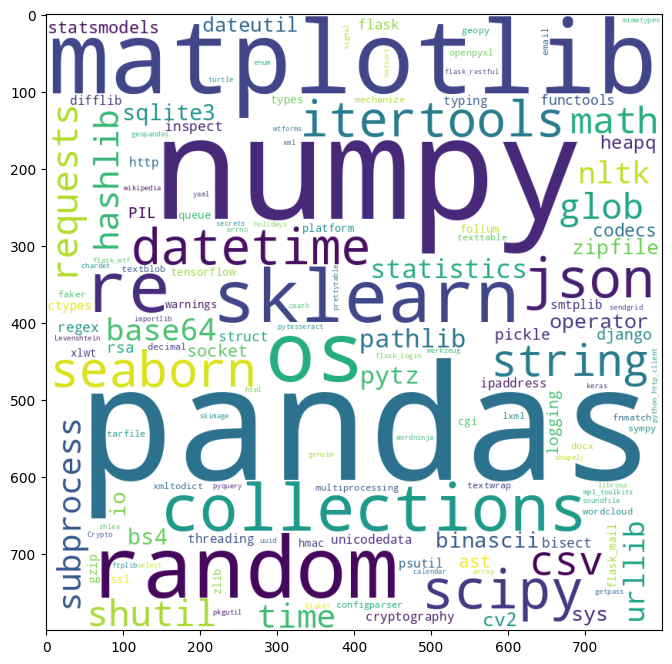

In [30]:
# wordcloud for the frequency of libraries in WildCodeBench
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 3).generate_from_frequencies(Counter([lib for b in benchmark_data for lib in b["libs"]]))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)

In [35]:
# wordcloud for the frequency of keywork in prompt in WildCodeBench
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 3).generate_from_frequencies(Counter([word for b in benchmark_data for word in re.findall(r'\w+', b["prompt"])]))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)

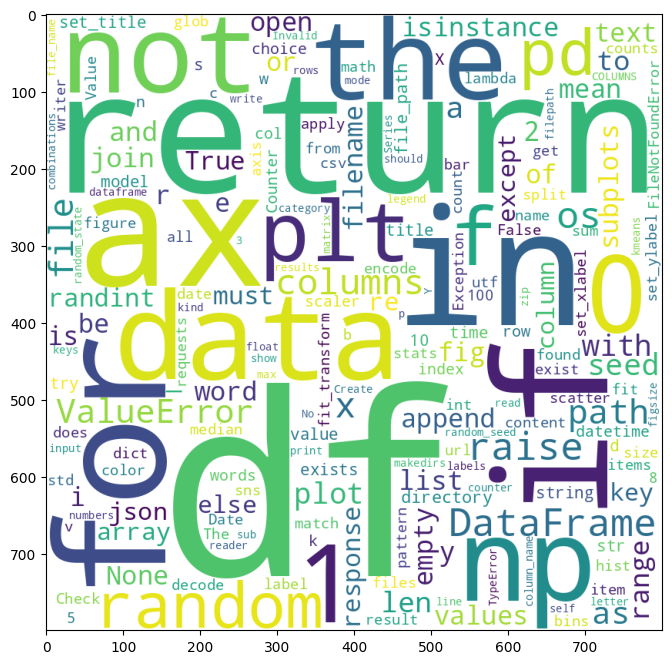

In [32]:
# wordcloud for the frequency of keywork in clean_canonical_solution in WildCodeBench
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 3).generate_from_frequencies(Counter([word for b in benchmark_data for word in re.findall(r'\w+', b["canonical_solution"])]))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)

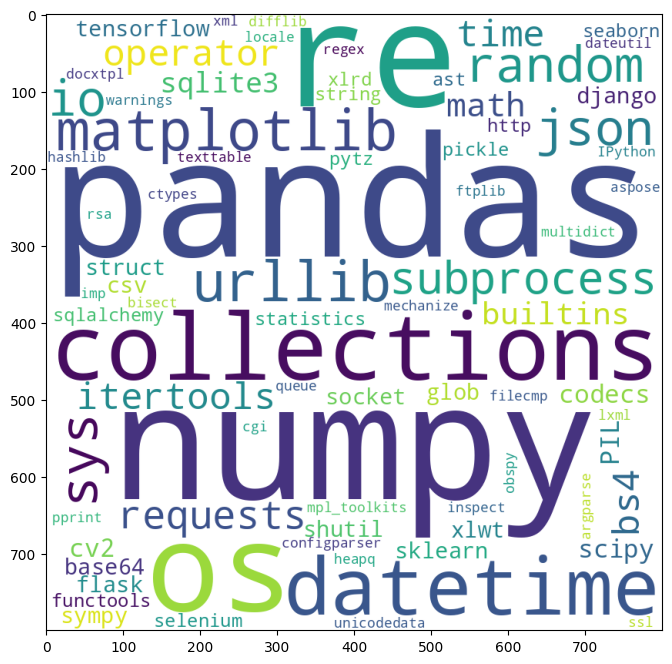

In [31]:
# wordcloud for the frequency of libraries in ODEX
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 3).generate_from_frequencies(Counter([lib for l in odex_data for lib in l["library"]]))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)

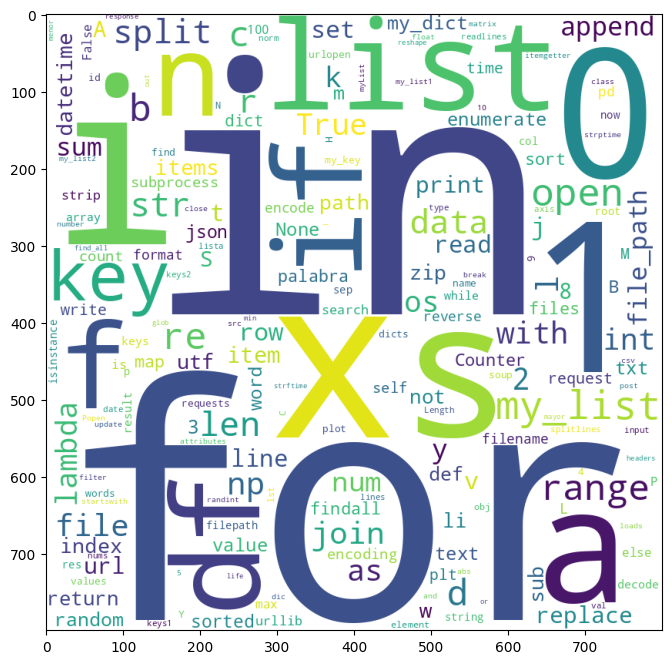

In [33]:
# wordcloud for the frequency of keywork in canonical_solution in ODEX
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 3).generate_from_frequencies(Counter([word for l in odex_data for word in re.findall(r'\w+', l["canonical_solution"])]))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)